# Using NEOS package

With the new `poliastro` version (0.7.0), a new package is included: [NEOs package](file:///C:/Users/Antonio/Desktop/Proyectos/poliastro/docs/source/html_output/api.html#module-poliastro.neos).

The docstrings of this package states the following:

> Functions related to NEOs and different NASA APIs. All of them are coded as part of SOCIS 2017 proposal.

So, first of all, an important question:

## What are NEOs?

NEO stands for near-Earth object. The Center for NEO Studies ([CNEOS](http://cneos.jpl.nasa.gov/)) defines NEOs as comets and asteroids that have been nudged by the gravitational attraction of nearby planets into orbits that allow them to enter the Earth’s neighborhood.

And what does "near" exactly mean? In terms of orbital elements, asteroids and comets can be considered NEOs if their perihelion (orbit point which is nearest to the Sun) is less than 1.3 au = 1.945 * 10<sup>8</sup> km from the Sun.

In [1]:
import matplotlib.pyplot as plt
plt.ion()

from astropy import time

from poliastro.twobody.orbit import Orbit
from poliastro.bodies import Earth
from poliastro.plotting import OrbitPlotter

## NeoWS module
This module make requests to [NASA NEO Webservice](https://api.nasa.gov/api.html#NeoWS), so you'll need an internet connection to run the next examples.

The simplest `neows` function is `orbit_from_name()`, which return an Orbit object given a name:

In [2]:
from poliastro.neos import neows

0.2226656050106755
1.8748628234034213 rad
1.6531074758822792


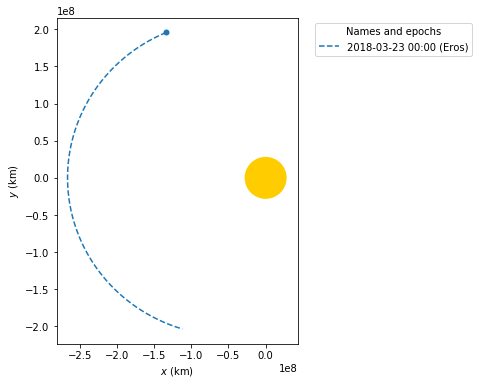

In [3]:
eros = neows.orbit_from_name('Eros')

frame = OrbitPlotter()
frame.plot(eros, label='Eros')

You can also search by IAU number or SPK-ID (there is a faster `neows.orbit_from_spk_id()` function in that case, although):

In [4]:
ganymed = neows.orbit_from_name('1036') # Ganymed IAU number
amor = neows.orbit_from_name('2001221') # Amor SPK-ID
eros = neows.orbit_from_spk_id('2000433') # Eros SPK-ID

frame = OrbitPlotter()
frame.plot(ganymed, label='Ganymed')
frame.plot(amor, label='Amor')
frame.plot(eros, label='Eros')

HTTPError: 429 Client Error:  for url: https://api.nasa.gov/neo/rest/v1/neo/2001221?api_key=DEMO_KEY

Since `neows` relies on [Small-Body Database browser](https://ssd.jpl.nasa.gov/sbdb.cgi) to get the SPK-ID given a body name, you can use the wildcards from that browser: `*` and `?`.

<div class="alert alert-info">Keep it in mind that `orbit_from_name()` can only return one Orbit, so if several objects are found with that name, it will raise an error with the different bodies.</div>

In [ ]:
neows.orbit_from_name('*alley')

<div class="alert alert-info">Note that epoch is provided by the Web Service itself, so if you need orbit on another epoch, you have to propagate it:</div>

In [ ]:
eros.epoch.iso

In [ ]:
epoch = time.Time(2458000.0, scale='tdb', format='jd')
eros_november = eros.propagate(epoch)
eros_november.epoch.iso

Given that we are using NASA APIs, there is a maximum number of requests. If you want to make many requests, it is recommended getting a [NASA API key](https://api.nasa.gov/index.html#apply-for-an-api-key). You can use your API key adding the `api_key` parameter to the function:

In [ ]:
neows.orbit_from_name('Toutatis', api_key='DEMO_KEY')

## DASTCOM5 module

This module can also be used to get NEOs orbit, in the same way that `neows`, but it have some advantages (and some disadvantages).

It relies on DASTCOM5 database, a NASA/JPL maintained asteroid and comet database. This database has to be downloaded at least once in order to use this module. According to its README, it is updated typically a couple times per day, but 
 potentially as frequently as once per hour, so you can download it whenever you want the more recently discovered bodies. This also means that, after downloading the file, you can use the database offline.
 
The file is a ~230 MB zip that you can manually [download](ftp://ssd.jpl.nasa.gov/pub/ssd/dastcom5.zip) and unzip in `~/.poliastro` or, more easily, you can use
```Python
dastcom5.download_dastcom5()
```

The main DASTCOM5 advantage over NeoWs is that you can use it to search not only NEOs, but any asteroid or comet. The easiest function is `orbit_from_name()`:

In [ ]:
from poliastro.neos import dastcom5

In [ ]:
atira = dastcom5.orbit_from_name('atira')[0] # NEO
wikipedia = dastcom5.orbit_from_name('wikipedia')[0] # Asteroid, but not NEO.
frame = OrbitPlotter()
frame.plot(atira, label='Atira (NEO)')
frame.plot(wikipedia, label='Wikipedia (asteroid)')

Keep in mind that this function returns a list of orbits matching your string. This is made on purpose given that there are comets which have several records in the database (one for each orbit determination in history) what allow plots like this one:

In [ ]:
halleys = dastcom5.orbit_from_name('1P')

frame = OrbitPlotter()
frame.plot(halleys[0], label='Halley')
frame.plot(halleys[5], label='Halley')
frame.plot(halleys[10], label='Halley')
frame.plot(halleys[20], label='Halley')
frame.plot(halleys[-1], label='Halley')

While `neows` can only be used to get Orbit objects, `dastcom5` can also provide asteroid and comet complete database.
Once you have this, you can get specific data about one or more bodies. The complete databases are `ndarrays`, so if you want to know the entire list of available parameters, you can look at the `dtype`, and they are also explained in
[documentation API Reference](http://docs.poliastro.space/en/latest/dastcom5 parameters.html):

In [ ]:
ast_db = dastcom5.asteroid_db()
comet_db = dastcom5.comet_db()
ast_db.dtype.names[:20] # They are more than 100, but that would be too much lines in this notebook :P

<div class="alert alert-info">Asteroid and comet parameters are not exactly the same (although they are very close):</div>

With these `ndarrays` you can classify asteroids and comets, sort them, get all their parameters, and whatever comes to your mind.

For example, NEOs can be grouped in several ways. One of the NEOs group is called `Atiras`, and is formed by NEOs whose orbits are contained entirely with the orbit of the Earth. They are a really little group, and we can try to plot all of these NEOs using `asteroid_db()`:

Talking in orbital terms, `Atiras` have an aphelion distance, `Q < 0.983 au` and a semi-major axis, ` a < 1.0 au`.
Visiting [documentation API Reference](http://docs.poliastro.space/en/latest/dastcom5 parameters.html), you can see that DASTCOM5 provides semi-major axis, but doesn't provide aphelion distance. You can get aphelion distance easily knowing perihelion distance (q, QR in DASTCOM5) and semi-major axis `Q = 2*a - q`, but there are probably many other ways.

In [ ]:
aphelion_condition = 2 * ast_db['A'] - ast_db['QR'] < 0.983
axis_condition = ast_db['A'] < 1.3 
atiras = ast_db[aphelion_condition & axis_condition]

The number of `Atira NEOs` we use using this method is:

In [ ]:
len(atiras)

Which is consistent with the [stats published by CNEOS](https://cneos.jpl.nasa.gov/stats/totals.html)

Now we're gonna plot all of their orbits, with corresponding labels, just because we love plots :)

In [ ]:
from poliastro.twobody.orbit import Orbit
from poliastro.bodies import Earth

earth = Orbit.from_body_ephem(Earth)

We only need to get the 16 orbits from these 16 `ndarrays`.

There are two ways:

* Gather all their orbital elements manually and use the `Orbit.from_classical()` function.
* Use the `NO` property (logical record number in DASTCOM5 database) and the `dastcom5.orbit_from_record()` function.

The second one seems easier and it is related to the current notebook, so we are going to use that one:

We are going to use `ASTNAM` property of DASTCOM5 database:

In [ ]:
frame = OrbitPlotter()

frame.plot(earth, label='Earth')

for record in atiras['NO']:
    ss = dastcom5.orbit_from_record(record)
    frame.plot(ss, color="#666666")

<div class="alert alert-warning">This slightly incorrect, given that Earth coordinates are in a different frame from asteroids. However, for the purpose of this notebook, the effect is barely noticeable.</div>

If we needed also the names of each asteroid, we could do:

In [ ]:
frame = OrbitPlotter()

frame.plot(earth, label='Earth')

for i in range(len(atiras)):
    record = atiras['NO'][i]
    label = atiras['ASTNAM'][i].decode().strip() # DASTCOM5 strings are binary
    ss = dastcom5.orbit_from_record(record)
    frame.plot(ss, label=label)

<div class="alert alert-info">We knew beforehand that there are no `Atira` comets, only asteroids (comet orbits are usually more eccentric), but we could use the same method with `com_db` if we wanted.</div>

Finally, another interesting function in `dastcom5` is `entire_db()`, which is really similar to `ast_db` and `com_db`, but it returns a `Pandas dataframe` instead of a `numpy ndarray`. The dataframe has asteroids and comets in it, but in order to achieve that (and a more manageable dataframe), a lot of parameters were removed, and others were renamed:

In [ ]:
db = dastcom5.entire_db()
db.columns

Also, in this function, DASTCOM5 data (specially strings) is ready to use (decoded and improved strings, etc):

In [ ]:
db[db.NAME == 'Halley'] # As you can see, Halley is the name of an asteroid too, did you know that?

Panda offers many functionalities, and can also be used in the same way as the `ast_db` and `comet_db` functions:

In [ ]:
aphelion_condition = (2 * db['A'] - db['QR']) < 0.983
axis_condition = db['A'] < 1.3 
atiras = db[aphelion_condition & axis_condition]

In [ ]:
len(atiras)

What? I said they can be used in the same way!

Dont worry :) If you want to know what's happening here, the only difference is that we are now working with comets too, and some comets have a negative semi-major axis!

In [ ]:
len(atiras[atiras.A < 0])

So, rewriting our condition:

In [ ]:
axis_condition = (db['A'] < 1.3) & (db['A'] > 0)
atiras = db[aphelion_condition & axis_condition]
len(atiras)